In [1]:
import warnings

warnings.filterwarnings("ignore")

# Retrieving Data from Chacolgenide Perovskites

```{admonition} Motivation 
:class:note

In this notebook we want to collect a dataset on structured data that will allow us to train a composition-property prediction model later on. But we want to focus on a specific class of materials called **chalcogenide perovskites**.

- We want to ensure that the output formulas retrieved can be parsed into a `pymatgen` `Composition` object. This is important to be able to reuse the extracted data with popular materials informatics packages, such as those leading in [MatBench](https://matbench.materialsproject.org/).
- We want to ensure control over  the stoichiometry of the compounds retrieved. We also want to ensure that the formulas fulfill the criteria of charge neutrality. For this, we will employ a constrained decoding approach as exemplify in the [constrained decoding]() notebook.
- We will validate if the formulas retrieved fulfill some stability criteria for being a perovskite compound. For this we will employ a similar approach as in the [validation example]() notebook.
```

## What are Chalcogenide Perovskites?

```{admonition} Background
:class:note

We aim to constrain our extraction pipeline to output formulas that adhere to specific chemical and structural criteria, focusing on **chalcogenide perovskite** compounds. 

Chalcogenide perovskites are a subclass of perovskites where the anions are chalcogens (**sulfur**, **selenium**, or **tellurium**). 

These materials are of great interest due to their unique properties that make them suitable for energy applications, such as:

- **Optoelectronic Properties**: They exhibit favorable band gaps and strong light absorption, making them ideal for photovoltaic applications.
- **Stability**: Compared to their halide counterparts, chalcogenide perovskites often show enhanced chemical stability.
- **Flexibility in Composition**: The ability to tune the composition allows for optimization of properties for specific applications like solar cells, photodetectors, and LEDs.
```


### The Perovskite-type Structure

The perovskite-type structure is defined based on the [mineral CaTiO₃](https://en.wikipedia.org/wiki/Calcium_titanate). To be classified as a perovskite, materials must exhibit close structural similarity to this archetype. Bretterniz and Schorr have clarified a [set of criteria](https://doi.org/10.1002/aenm.201802366) to determine whether a material should be called perovskite.{cite}`breternitz_what_2018`

1. **Stoichiometry**: ABX₃, or at least an A🟠: B🔵: X🔴 ratio of 1:1:3.
2. **B-cation Coordination**: Octahedral (or distorted octahedra) coordination.
3. **3D Network**: The [BX₆] octahedra should form an all-corner-sharing 3D network.

```{figure} ./BaZrS3.png
---
scale: 30%
name: A chalcogenide perovskite structural model of BaZrS₃
---
A chalcogenide perovskite structural model of BaZrS₃
```


For this task, we want to retrieve the structure dataset from the review paper [Chalcogenide Perovskites: Tantalizing Prospects, Challenging Materials](https://onlinelibrary.wiley.com/doi/10.1002/adom.202101704).{cite}`Sopiha2021`

```{admonition} Parsing papers
:class: note dropdown

For this notebook, we already provide the paper in Markdown format. If you want to extract the text from the paper yourself, you can use Nougat.
A detailed example of how to do this can be found in the [Nougat example notebook]().

```{warning}
Even the "small" Nougat model might be slow on a computer without GPU. 
In addition, this call will download relatively large model checkpoints.
```

You can run Nougat using a helper function from our package. 

```
from llmstructdata.utils import convert_pdf_to_markdown_text

text = convert_pdf_to_markdown_text(
    "paper.pdf",  model="0.1.0-base", no_skipping=True
)
```

## Constraining the formulas to have a 1:1:3 stoichiometry and charge neutrality

To do this, we will follow a screening approach starting from a set of elements to form combinations for potential compounds. We will use [`pymatgen`](https://pymatgen.org/) to generate a list of ternary chalcogenide perovskites that fulfill at least the first criterion for sulfide and selenide compounds (the 1:1:3 stoichiometry one). 
The [`oxi_state_guesses` method](https://pymatgen.org/pymatgen.core.html#pymatgen.core.composition.Composition.oxi_state_guesses) of the `pymatgen` `Composition` object will ensure the stoichiometry is correct and that the compound is charge balanced. This is performed by using guessed oxidation states for the elemental combinations screened.

In [2]:
from pymatgen.core import Composition


def generate_compositions(element_symbols, anions=["S", "Se"]):
    """
    Generate valid compositions for perovskite materials.

    This function takes a list of element symbols and generates valid compositions
    for perovskite materials by combining unique pairs of cations with specified anions.
    The generated compositions are checked for validity and oxidation states are guessed.

    Parameters:
    - element_symbols (list): A list of element symbols representing the cations.
    - anions (list, optional): A list of anion symbols. Default is ["S", "Se"].

    Returns:
    - valid_compositions (list): A list of tuples containing the reduced formula and
      guessed oxidation states for each valid composition.

    Example usage:
    >>> element_symbols = ["Ba", "Ti", "O"]
    >>> generate_compositions(element_symbols)
    [('BaTiO3', {'Ba': 2, 'Ti': 4, 'O': -2})]

    """
    valid_compositions = []

    for i, cation1 in enumerate(element_symbols):
        for cation2 in element_symbols[i + 1 :]:  # Ensure unique pairs
            if cation1 != cation2:  # Ensure that two cations are not the same
                for anion in anions:
                    formula = f"{cation1}{cation2}{anion}3"  # We state here the stoichiometry of the perovskite
                    try:
                        comp = Composition(formula)
                        # Guess oxidation states
                        oxi_states_override = {anion: [-2]}
                        oxi_state_guesses = comp.oxi_state_guesses(
                            oxi_states_override=oxi_states_override
                        )

                        for guess in oxi_state_guesses:
                            if all(val is not None for val in guess.values()):
                                valid_compositions.append((comp.reduced_formula, guess))
                                break
                    except ValueError:
                        continue  # Skip invalid combinations

    return valid_compositions


element_symbols = [
    "Ba",
    "Hf",
    "Gd",
    "Fe",
    "O",
    "La",
    "Yb",
    "U",
    "Sc",
    "Ce",
    "Er",
    "Nb",
    "Sn",
    "Ta",
    "Pb",
    "V",
    "Ti",
    "Zr",
    "Nd",
    "Lu",
    "Y",
    "Pr",
    "Ca",
    "Sr",
    "Ho",
    "Tm",
    "Sm",
    "Cu",
    "Dy",
    "Eu",
    "Tb",
    "Cr",
]

valid_compositions = generate_compositions(element_symbols)

for formula, oxi_states in valid_compositions:
    print(f"Formula: {formula}, Oxidation States: {oxi_states}")

print(f"Number of valid compositions: {len(valid_compositions)}")

valid_formulas = [formula for formula, _ in valid_compositions]

Formula: BaHfS3, Oxidation States: {'Ba': 2.0, 'Hf': 4.0, 'S': -2.0}
Formula: BaHfSe3, Oxidation States: {'Ba': 2.0, 'Hf': 4.0, 'Se': -2.0}
Formula: BaUS3, Oxidation States: {'Ba': 2.0, 'U': 4.0, 'S': -2.0}
Formula: BaUSe3, Oxidation States: {'Ba': 2.0, 'U': 4.0, 'Se': -2.0}
Formula: BaCeS3, Oxidation States: {'Ba': 2.0, 'Ce': 4.0, 'S': -2.0}
Formula: BaCeSe3, Oxidation States: {'Ba': 2.0, 'Ce': 4.0, 'Se': -2.0}
Formula: BaNbS3, Oxidation States: {'Ba': 2.0, 'Nb': 4.0, 'S': -2.0}
Formula: BaNbSe3, Oxidation States: {'Ba': 2.0, 'Nb': 4.0, 'Se': -2.0}
Formula: BaSnS3, Oxidation States: {'Ba': 2.0, 'Sn': 4.0, 'S': -2.0}
Formula: BaSnSe3, Oxidation States: {'Ba': 2.0, 'Sn': 4.0, 'Se': -2.0}
Formula: BaTaS3, Oxidation States: {'Ba': 2.0, 'Ta': 4.0, 'S': -2.0}
Formula: BaTaSe3, Oxidation States: {'Ba': 2.0, 'Ta': 4.0, 'Se': -2.0}
Formula: BaPbS3, Oxidation States: {'Ba': 2.0, 'Pb': 4.0, 'S': -2.0}
Formula: BaPbSe3, Oxidation States: {'Ba': 2.0, 'Pb': 4.0, 'Se': -2.0}
Formula: BaVS3, Oxidatio

Our screening has resulted in almost 800 potential compounds. We will use a constrained decoding approach to ensure that the formulas retrieved are form this list.

### Defining a data schema and extracting the data for 1:1:3 compounds

To enable constrained decoding, we will use one of the most popular packages for this task [`instructor`](https://jxnl.github.io/instructor/).
It is built on [`pydantic`](https://docs.pydantic.dev/latest/) and can leverage function calling and JSON-mode of the OpenAI API as well as other constrained sampling approaches.
This part of the notebook is based on the example provided in the [constrained decoding example notebook](index.ipynb).

For most constrained generation tasks, we need to define a data schema.
The most common way to do so is to use `pydantic` data classes. For more information on how to define data classes, see the [`pydantic` documentation](https://pydantic-docs.helpmanual.io/) and our notebook on [constrained decoding](index.ipynb).

If we aim to extract valid compositions for chalcogenide perovskites, we can refine our schema to ensure that the extracted formulas are informed by our pre-compiled list from the screening process. Like this, we can ensure that the extracted formulas must comply from the pre-computed `valid_formulas` and can be used for further analysis.

```python
    formula: Optional[Literal[tuple(valid_formulas)]] = Field(
        None,
        title="Formula",
        description="Chemical formula of the chalcogenide perovskite.",
    )
```

In [3]:
from pydantic import BaseModel, Field
from typing import Optional, Literal, List
from litellm import completion
import instructor
from dotenv import load_dotenv

_ = load_dotenv("../../.env", override=True)

In [4]:
class ChalcogenidePerovskite(BaseModel):
    bandgap: Optional[float] = Field(
        None,
        title="Bandgap",
        description="Bandgap of the chalcogenide perovskite. Must be greater or equal to 0.",
        ge=0,
    )
    formula: Optional[Literal[tuple(valid_formulas)]] = Field(
        None,
        title="Formula",
        description="Chemical formula of the chalcogenide perovskite.",
    )

In [5]:
# Example usage
example = ChalcogenidePerovskite(
    bandgap=1.5,
    formula="BaZrS3",
)

print(example.model_dump())

{'bandgap': 1.5, 'formula': 'BaZrS3'}


We will also define an unconstrained model for comparison purposes where we will not enforce the stoichiometry and charge neutrality constraints, and we will simply retrieve the formulas as strings.

In [6]:
class UnconstrainedChalcogenidePerovskite(BaseModel):
    bandgap: Optional[float] = Field(
        None,
        title="Bandgap",
        description="Bandgap of the chalcogenide perovskite. Must be greater or equal to 0.",
    )
    formula: Optional[str] = Field(
        None,
        title="Formula",
        description="Chemical formula of the chalcogenide perovskite.",
    )


We can now use `instructor` to "patch" the OpenAI API client to ensure that our output fulfills the schema. First, we will start by loading the text of our paper already in Markdown format.

In [7]:
# open paper.md as text to pass to the model

with open("paper.md", "r", encoding="utf-8") as file:
    text = file.read()

In [8]:
messages = [
    {
        "role": "system",
        "content": "You are an expert chemist and your work is to extract information about perovskites from the text provided according to the schema.",
    },
    {
        "role": "user",
        "content": f"""The goal is to extract compositions and bandgaps from chalcogenide perovskites.
        We want to extract as many entries as possible. If you find several instances of bandgaps in the text, please extract all of them.
        You MUST extract all the formulas/bandgaps pair that you find in the text. If you keep on finding more, keep on extending the list.

        Extract the information from the following text:

        {text}""",
    },
]

```{margin}
You can choose different models, e.g. of a different provider, by simply changing the model name in the `model` variable.
```

In [11]:
client = instructor.from_litellm(completion)
model = "anthropic/claude-3-5-sonnet-20240620"

In [12]:
unconstrained_answer = client.chat.completions.create(
    model=model,
    response_model=List[UnconstrainedChalcogenidePerovskite],
    temperature=0,
    max_retries=2,
    # caching=True,
    messages=messages,
)

In [13]:
print(len(unconstrained_answer))
unconstrained_answer

16


[UnconstrainedChalcogenidePerovskite(bandgap=1.75, formula='BaZrS3'),
 UnconstrainedChalcogenidePerovskite(bandgap=1.82, formula='BaZrS3'),
 UnconstrainedChalcogenidePerovskite(bandgap=1.89, formula='BaZrS3'),
 UnconstrainedChalcogenidePerovskite(bandgap=1.94, formula='BaZrS3'),
 UnconstrainedChalcogenidePerovskite(bandgap=2.17, formula='BaHfS3'),
 UnconstrainedChalcogenidePerovskite(bandgap=2.06, formula='BaHfS3'),
 UnconstrainedChalcogenidePerovskite(bandgap=2.05, formula='SrZrS3'),
 UnconstrainedChalcogenidePerovskite(bandgap=2.14, formula='SrZrS3'),
 UnconstrainedChalcogenidePerovskite(bandgap=2.32, formula='SrHfS3'),
 UnconstrainedChalcogenidePerovskite(bandgap=2.41, formula='SrHfS3'),
 UnconstrainedChalcogenidePerovskite(bandgap=1.76, formula='BaZr(S0.6Se0.4)3'),
 UnconstrainedChalcogenidePerovskite(bandgap=1.63, formula='Ba(Zr0.95Ti0.05)S3'),
 UnconstrainedChalcogenidePerovskite(bandgap=1.51, formula='Ba(Zr0.96Ti0.04)S3'),
 UnconstrainedChalcogenidePerovskite(bandgap=3.0, formul

Let's save our extracted results.

In [14]:
# save the results to a json file
import json

unconstrained_data = [item.model_dump() for item in unconstrained_answer]
with open("unconstrained_data.json", "w") as file:
    json.dump(unconstrained_data, file)

In [15]:
constrained_answer = client.chat.completions.create(
    model=model,
    response_model=List[ChalcogenidePerovskite],
    temperature=0,
    max_retries=2,
    # caching=True,
    messages=messages,
)

In [16]:
print(len(constrained_answer))
constrained_answer

7


[ChalcogenidePerovskite(bandgap=1.75, formula='BaZrS3'),
 ChalcogenidePerovskite(bandgap=2.17, formula='BaHfS3'),
 ChalcogenidePerovskite(bandgap=2.05, formula='SrZrS3'),
 ChalcogenidePerovskite(bandgap=2.32, formula='SrHfS3'),
 ChalcogenidePerovskite(bandgap=1.76, formula='BaZrS3'),
 ChalcogenidePerovskite(bandgap=1.63, formula='BaZrS3'),
 ChalcogenidePerovskite(bandgap=3.0, formula='YScS3')]

Let's also save the results of our constrained retrieval. 

In [17]:
constrained_data = [item.model_dump() for item in constrained_answer]
with open("constrained_data.json", "w") as file:
    json.dump(constrained_data, file)

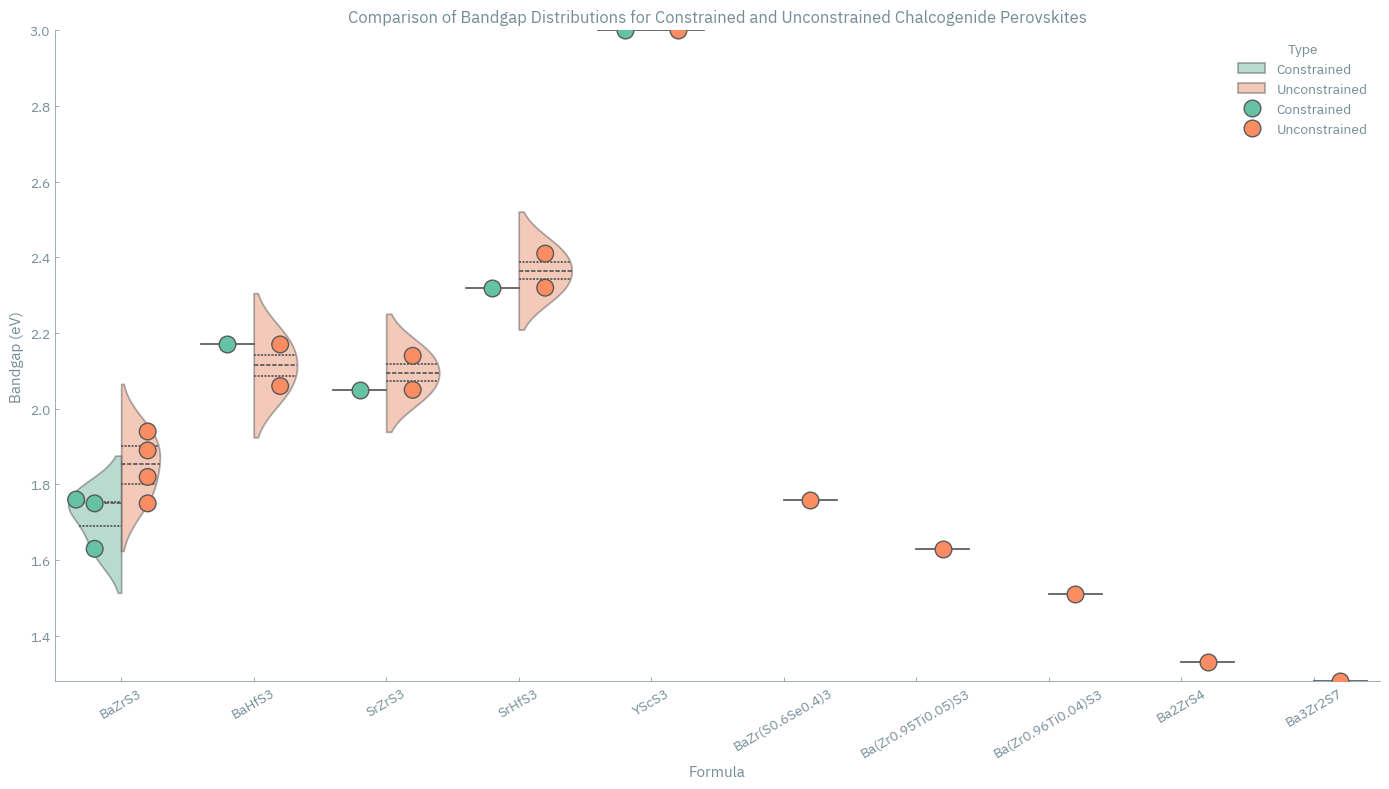

In [18]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Load the data
with open("constrained_data.json", "r") as file:
    constrained_data = json.load(file)

with open("unconstrained_data.json", "r") as file:
    unconstrained_data = json.load(file)

# Create a DataFrame for the constrained data
constrained_df = pd.DataFrame(constrained_data)
constrained_df["Type"] = "Constrained"

# Create a DataFrame for the unconstrained data
unconstrained_df = pd.DataFrame(unconstrained_data)
unconstrained_df["Type"] = "Unconstrained"

# Combine the two DataFrames
combined_data = pd.concat([constrained_df, unconstrained_df], ignore_index=True)

# Create the violin plot with swarm plot overlay
plt.figure(figsize=(14, 8))
sns.violinplot(
    x="formula",
    y="bandgap",
    hue="Type",
    data=combined_data,
    split=True,
    inner="quart",
    palette="Set2",
    alpha=0.5,
)
sns.swarmplot(
    x="formula",
    y="bandgap",
    hue="Type",
    data=combined_data,
    dodge=True,
    palette="Set2",
    alpha=1,
    size=12,
    linewidth=1,
)

# Adjust plot
plt.title(
    "Comparison of Bandgap Distributions for Constrained and Unconstrained Chalcogenide Perovskites"
)
plt.xlabel("Formula")
plt.ylabel("Bandgap (eV)")
plt.xticks(rotation=30)
plt.legend(title="Type", loc="upper right")
plt.tight_layout()
plt.show()

The plot shows the distribution of the bandgap values for the compounds retrieved from both pipelines. For the pipeline with the constrained formula requirement (green markers), there are no values extracted for the following invalid formulas:

- BaZr(S<sub>1-x</sub>Se<sub>x</sub>)<sub>3</sub>
- Ba(Zr<sub>1-x</sub>Ti<sub>x</sub>)S<sub>3</sub>
- Ba<sub>2</sub>ZrS<sub>4</sub>
- Ba<sub>3</sub>Zr<sub>2</sub>Se<sub>7</sub>

For the compounds retrieved from both pipelines, the violin plots are symmetrical showing that the bandgap values are extracted similarly. 

## Validating the output to be a perovskite type structure

Before, we have ensured that the output formulas follow **the stoichiometry criteria of 1:1:3** for a perovskite-type compound. 
Now, we aim to validate whether a given set of chemical formulas can fulfill the other criteria:

1. **B-cation Coordination**: Octahedral (or distorted octahedra) coordination.
2. **3D Network**: The [BX₆] octahedra should form an all-corner-sharing 3D network.

This is something that is typically not reported in the text of the papers. However, we can calculate **the tolerance factor** that gives us a proxy about whether a perovskite structure is stable for a given composition and used this as **validation** criteria in our extraction pipeline.

```{admonition} The Tolerance and Octahedral Factors
:class: tip

**Tolerance Factor \(*t*\)**: This is a dimensionless number calculated from the ionic radii of the constituent ions. For a stable **oxide perovskite-type** structure, the tolerance factor should ideally be in the range of 0.8 to 1.0.

$$
t = \frac{r_A + r_O}{\sqrt{2} (r_B + r_O)}
$$

where *r<sub>A</sub>*, *r<sub>B</sub>*, and *r<sub>O</sub>* are the ionic radii of the A-site cation, B-site cation, and oxygen anion, respectively.

Many modifications to the tolerance factor formula have been proposed. We will use a modified formula that incorporates electronegativity differences in our validation process, specifically for chacolgenide perovskites as reported by {cite:t}`jess_phase_2022`

```

To determine the tolerance factor and octahedral factor, we perform the following steps:

1. **Find Cations and Oxidation States**: We identify the A-site and B-site cations and their oxidation states for a given 1:1:3 compound formula.
2. **Fetch Elemental Properties**: We retrieve ionic radii and electronegativities of the elements involved using the `pymatgen` and `mendeleev` libraries.
3. **Calculate Modified Tolerance Factor**: We use a modified formula for the tolerance factor that incorporates electronegativity differences:
   
   $$ 
   t^* = \frac{\left( \frac{\Delta \chi_{(A-X)}}{\Delta \chi_{(A-O)}} \right) (r_A + r_X)}{\sqrt{2} \left( \frac{\Delta \chi_{(B-X)}}{\Delta \chi_{(B-O)}} \right) (r_B + r_X)} 
   $$

4. **Validation**: We validate the structure by checking if the calculated tolerance factor fall within the acceptable ranges for sulfide and selenide compounds.


Let's start by fetching the shannon ionic radii of the species involved in the perovskite structure. And store this in our working dataframe.

Get a dicctionary for the elements of the formula and guess the oxidation states. 

In [19]:
def get_oxidation_states(formula):
    """
    Extracts the oxidation states for each element in a given chemical formula.

    This function takes a chemical formula as input and returns a dictionary where the keys are the element symbols and the values are the oxidation states. It specifically fixes the oxidation states for sulfur (S) and selenium (Se) to -2.

    Parameters:
    - formula (str): The chemical formula for which the oxidation states are to be determined.

    Returns:
    - dict: A dictionary with element symbols as keys and their oxidation states as values. The oxidation states are determined based on the best guess from the pymatgen library, with fixed values for S and Se.

    Example:
    >>> get_oxidation_states("ZrBaS3")
    {'Zr': 4.0, 'Ba': 2.0, 'S': -2.0}
    """
    comp = Composition(formula)
    guesses = comp.oxi_state_guesses(oxi_states_override={"S": [-2], "Se": [-2]})
    return guesses[0]

Let's make sure to order the elements so they follow the A, B, X cations correcly, with A being the largest cation, B the transition metal, and X the anion. 

In [20]:
def order_oxidation_states(oxidation_states):
    """
    Orders the oxidation states of elements in a given dictionary, separating cations and anions.

    This function takes a dictionary of elements with their oxidation states and returns a new dictionary with cations (positive oxidation states) sorted in ascending order,
    followed by anions (negative oxidation states).
    This ordering is useful for example to handle A and B cations being 2+ and 4+ respectively.

    Parameters:
    - oxidation_states (dict): A dictionary where keys are element symbols (str) and values are their oxidation states (int).

    Returns:
    - dict: A new dictionary with sorted cations followed by anions. Cations are sorted in ascending order based on their oxidation states.

    Example:
    >>> oxidation_states = {'Zr': 4.0, 'Ba': 2.0, 'S': -2.0}
    >>> order_oxidation_states(oxidation_states)
    {'Ba': 2.0, 'Zr': 4.0, 'S': -2.0}
    """
    cations = {el: ox for el, ox in oxidation_states.items() if ox > 0}
    anion = {el: ox for el, ox in oxidation_states.items() if ox < 0}

    sorted_cations = {
        k: v for k, v in sorted(cations.items(), key=lambda item: item[1])
    }

    return {**sorted_cations, **anion}

Here we will retrieve the ionic radii and the electronegativity for the elements in the formula using the `mendeleev` python package. 

In [33]:
from mendeleev.fetch import fetch_ionic_radii, fetch_table
import pandas as pd
import math

# Fetch the elements table to get the mapping from symbol to atomic number
elements_df = fetch_table("elements")
symbol_to_atomic_number = dict(zip(elements_df["symbol"], elements_df["atomic_number"]))


def get_ionic_radius(symbol, charge, site):
    """
    Retrieves the ionic radius of an element given its symbol, charge, and site.

    This function looks up the ionic radius of an element based on its chemical symbol, ionic charge, and the site it occupies in a crystal structure (A, B, or X sites).
    The function uses a predefined DataFrame that contains ionic radii information from the medeleev package.
    The coordination number (CN) is determined based on the site: XII for A site, VI for both B and X sites.
    The function returns the ionic radius for the specified conditions if available.

    Parameters:
    - symbol (str): The chemical symbol of the element (e.g., 'Fe').
    - charge (int): The ionic charge of the element (e.g., 2 or -2).
    - site (str): The site the element occupies in a crystal structure ('A', 'B', or 'X').

    Returns:
    - float or None: The ionic radius of the element for the given charge and site if available; otherwise, None.

    Example:
    >>> get_ionic_radius("Zr", 4, "B")
    72.0
    """
    # Get the atomic number for the given symbol
    atomic_number = symbol_to_atomic_number.get(symbol)

    if atomic_number is None:
        return None

    # Determine coordination number based on site
    if site == "A":
        cn = "XII"
    elif site == "B":
        cn = "VI"
    elif site == "X":
        cn = "VI"
    else:
        return None

    # Fetch the ionic radii table
    ionic_radii_df = fetch_ionic_radii(radius="ionic_radius")

    # Check if the determined coordination number is a valid column
    if cn not in ionic_radii_df.columns:
        return None

    # Filter the DataFrame for the specific atomic number and charge
    element_data = ionic_radii_df[
        (ionic_radii_df.index.get_level_values("atomic_number") == atomic_number)
        & (ionic_radii_df.index.get_level_values("charge") == charge)
    ]

    # Extract the ionic radius for the given coordination number
    if element_data.empty:
        return None

    ionic_radius = element_data[cn].values

    if len(ionic_radius) > 0 and pd.notna(ionic_radius[0]):
        return ionic_radius[0]
    else:
        return None


def get_electronegativity(symbol):
    """
    Retrieves the Pauling electronegativity of an element given its symbol.

    This function queries a pre-fetched table of elements from mendeleev to find the Pauling electronegativity value for a given element symbol.
    The table is expected to contain at least two columns: 'symbol' and 'en_pauling', where 'symbol' represents the chemical symbol of the element and 'en_pauling' its electronegativity according to Pauling scale.
    If the symbol is not found in the table, the function returns None.

    Parameters:
    - symbol (str): The chemical symbol of the element (e.g., 'O' for oxygen).

    Returns:
    - float or None: The Pauling electronegativity of the element if available; otherwise, None.

    Example:
    >>> get_electronegativity('Zr')
    1.33
    """
    elements_df = fetch_table("elements")
    en_pauling = elements_df.set_index("symbol")["en_pauling"].to_dict()
    return en_pauling.get(symbol)

```{admonition} The Tabulated Shannon Radii Values
:class: warning

The Shannon ionic radii are tabulated for a variety of coordination numbers and oxidation states. 
We  use the values for the most common coordination number of 6 (octahedral) for the B cation, which is commonly found. For the A cation, we decided to fix the coordination number to 12. For some elements in a given oxidation state, Shannon radii data in the 12 coordination number might not be available. In those cases, we will not be able to calculate the tolerance factor. An alternative approach would be similar to the one proposed by {cite:t}`jess_phase_2022` where they perform a linear extrapolation to determine the ionic radii for the A cation in the 12 coordination number.
```

In [34]:
def calculate_modified_tolerance_factor(
    A_symbol, A_charge, B_symbol, B_charge, X_symbol="S", X_charge=-2
):
    """
    Calculates the modified tolerance factor for a given perovskite structure.

    This function computes the modified tolerance factor (t*) for a perovskite structure based on the ionic radii and electronegativities of its constituent elements. The modified tolerance factor is a measure used to predict the stability of perovskite structures. It incorporates both ionic radii and electronegativity differences between the A-site, B-site, and X-site elements.

    Parameters:
    - A_symbol (str): Chemical symbol for the A-site element.
    - A_charge (int): Ionic charge of the A-site element.
    - B_symbol (str): Chemical symbol for the B-site element.
    - B_charge (int): Ionic charge of the B-site element.
    - X_symbol (str, optional): Chemical symbol for the X-site element. Defaults to 'S'.
    - X_charge (int, optional): Ionic charge of the X-site element. Defaults to -2.

    Returns:
    - float or None: The calculated modified tolerance factor (t*), or None if any of the required ionic radii or electronegativities cannot be retrieved.

    Example:
    >>> calculate_modified_tolerance_factor('Ba', 2, 'Zr', 4, 'S', -2)
    1.0660635594441457
    """
    r_A = get_ionic_radius(A_symbol, A_charge, "A")
    r_B = get_ionic_radius(B_symbol, B_charge, "B")
    r_X = get_ionic_radius(X_symbol, X_charge, "X")

    # Ensure radii are retrieved successfully
    if r_A is None or r_B is None or r_X is None:
        print(
            f"Failed to retrieve ionic radii for: A({A_symbol}, {A_charge}), B({B_symbol}, {B_charge}), X({X_symbol}, {X_charge})"
        )
        return None

    chi_A_X = get_electronegativity(A_symbol) - get_electronegativity(X_symbol)
    chi_A_O = get_electronegativity(A_symbol) - get_electronegativity("O")
    chi_B_X = get_electronegativity(B_symbol) - get_electronegativity(X_symbol)
    chi_B_O = get_electronegativity(B_symbol) - get_electronegativity("O")

    # Ensure electronegativities are retrieved successfully
    if chi_A_X is None or chi_A_O is None or chi_B_X is None or chi_B_O is None:
        print(
            f"Failed to retrieve electronegativity for: A({A_symbol}), B({B_symbol}), X({X_symbol})"
        )
        return None

    t_star = (chi_A_X / chi_A_O * (r_A + r_X)) / (
        math.sqrt(2) * chi_B_X / chi_B_O * (r_B + r_X)
    )
    return t_star


def calculate_modified_tolerance_factor_from_formula(formula):
    """
    Calculates the modified tolerance factor from a chemical formula.

    This function extracts the oxidation states from a given chemical formula, orders them, and then calculates the modified tolerance factor (t*) for the resulting perovskite structure.
    It is a convenience function that allows for the calculation of t* directly from a chemical formula, abstracting away the steps of oxidation state extraction and ordering.

    Parameters:
    - formula (str): The chemical formula from which to calculate the modified tolerance factor.

    Returns:
    - float or None: The calculated modified tolerance factor (t*), or None if the calculation cannot be completed due to missing ionic radii or electronegativities.

    Example:
    >>> calculate_modified_tolerance_factor_from_formula('BaZrS3')
    1.0660635594441457
    """
    oxidation_states = get_oxidation_states(formula)
    oxidation_states = order_oxidation_states(oxidation_states)

    A_symbol, A_charge = list(oxidation_states.items())[0]
    B_symbol, B_charge = list(oxidation_states.items())[1]
    X_symbol, X_charge = list(oxidation_states.items())[2]

    t_star = calculate_modified_tolerance_factor(
        A_symbol, A_charge, B_symbol, B_charge, X_symbol, X_charge
    )
    return t_star

In [35]:
from pymatgen.core import Element


def is_perovskite(formula):
    """
    Determines if a given formula represents a perovskite structure based on the modified tolerance factor.

    This function calculates the modified tolerance factor (t*) for a given chemical formula and determines if the formula represents a perovskite structure.
    The criteria for being considered a perovskite are based on the range of t* values, which differ for sulfides and selenides due to their distinct structural requirements.

    Parameters:
    - formula (str): The chemical formula to evaluate for perovskite structure suitability.

    Returns:
    - bool: True if the formula represents a perovskite structure based on the calculated t*; otherwise, False.

    Note:
    - The function specifically checks for the presence of sulfur (S) or selenium (Se) in the formula to apply different t* boundaries for sulfides and selenides, respectively.

    Example:
    >>> is_perovskite('BaZrS3')
    True
    """
    t_star = calculate_modified_tolerance_factor_from_formula(formula)

    if t_star is None:
        return False

    # Define the boundaries for sulfides and selenides
    elif Element("S") in Composition(formula).elements:
        return 0.9 <= t_star <= 1.09
    elif Element("Se") in Composition(formula).elements:
        return 1.01 <= t_star <= 1.05
    else:
        return False

### Extracting the data for 1:1:3 compounds that are stable in a perovskite-type structure

We will use now our `is_perovskite` function to validate the extracted formulas. For that we will use the `field_validator` decorator from `pydantic`.

```{admonition} Using field validators can create additional LLM calls
:class: warning

Utilizing validators such as `field_validator` within your notebook may result in additional LLM calls. Some of this cases are discussed in this [blog post](https://hamel.dev/blog/posts/prompt/#validation) from Hamel Husain.
```

In [36]:
from pydantic import BaseModel, field_validator

# Create the model
class ValidatedChalcogenidePerovskite(BaseModel):
    bandgap: Optional[float] = Field(
        None,
        title="Bandgap",
        description="Bandgap of the chalcogenide perovskite. Must be greater or equal to 0.",
        ge=0,
    )
    formula: Optional[Literal[tuple(valid_formulas)]] = Field(
        None,
        title="Formula",
        description="Chemical formula of the chalcogenide perovskite.",
    )

    @field_validator("formula")
    def validate_formula(cls, value):
        if value is not None and not is_perovskite(value):
            raise ValueError(f"Invalid formula for a chalcogenide perovskite: {value}")
        return value


# Example usage
valid_example = ValidatedChalcogenidePerovskite(
    bandgap=1.5,
    formula="BaZrS3",
)

# non_valid_example = ValidatedChalcogenidePerovskite(
#     bandgap=1.5,
#     formula="SrSnSe3",
# )

print(example.model_dump())

{'bandgap': 1.5, 'formula': 'BaZrS3'}


Great! let's run our extraction with our new model that ensures the output formulas are valid chalcogenide perovskites.

In [37]:
validated_answer = client.chat.completions.create(
    model=model,
    response_model=List[ValidatedChalcogenidePerovskite],
    temperature=0,
    max_retries=2,
    caching=True,
    messages=messages,
)

print(len(validated_answer))
validated_answer

Failed to retrieve ionic radii for: A(Y, 3.0), B(Sc, 3.0), X(S, -2.0)
13


[ValidatedChalcogenidePerovskite(bandgap=1.75, formula='BaZrS3'),
 ValidatedChalcogenidePerovskite(bandgap=1.82, formula='BaZrS3'),
 ValidatedChalcogenidePerovskite(bandgap=1.89, formula='BaZrS3'),
 ValidatedChalcogenidePerovskite(bandgap=1.94, formula='BaZrS3'),
 ValidatedChalcogenidePerovskite(bandgap=2.17, formula='BaHfS3'),
 ValidatedChalcogenidePerovskite(bandgap=2.06, formula='BaHfS3'),
 ValidatedChalcogenidePerovskite(bandgap=2.05, formula='SrZrS3'),
 ValidatedChalcogenidePerovskite(bandgap=2.14, formula='SrZrS3'),
 ValidatedChalcogenidePerovskite(bandgap=2.32, formula='SrHfS3'),
 ValidatedChalcogenidePerovskite(bandgap=2.41, formula='SrHfS3'),
 ValidatedChalcogenidePerovskite(bandgap=1.76, formula='BaZrS3'),
 ValidatedChalcogenidePerovskite(bandgap=1.63, formula='BaZrS3'),
 ValidatedChalcogenidePerovskite(bandgap=1.51, formula='BaZrS3')]

In [34]:
# save the results to a json file

validated_data = [item.model_dump() for item in validated_answer]
with open("validated_data.json", "w") as file:
    json.dump(validated_data, file)

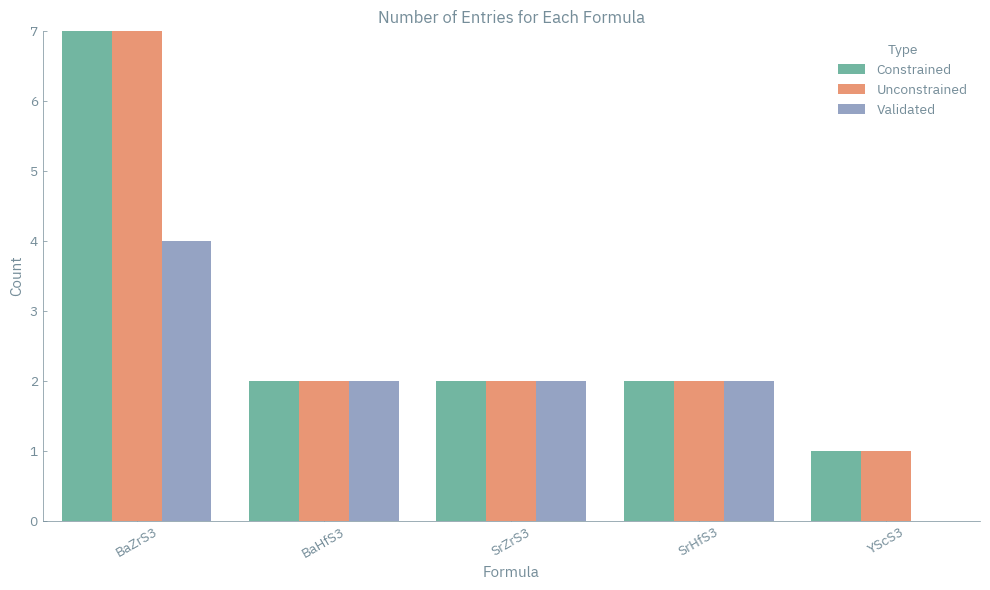

In [35]:
# Load the data

with open("validated_data.json", "r") as file:
    validated_data = json.load(file)

# Create a DataFrame for the validated data

validated_df = pd.DataFrame(validated_data)
validated_df["Type"] = "Validated"

# Combine the two DataFrames
conclusion_df = pd.concat([combined_data, validated_df], ignore_index=True)

# do a bar plot of the number of entries for each formula color coded by the type

plt.figure(figsize=(10, 6))
sns.countplot(x="formula", hue="Type", data=conclusion_df, palette="Set2")
plt.title("Number of Entries for Each Formula")
plt.xlabel("Formula")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [36]:
# dump conclusion_df to a csv file

conclusion_df.to_csv("conclusion_df.csv", index=False)

## Conclusions

In this notebook, we successfully extracted and analyzed structured data from a publication focusing on chalcogenide perovskites with LLMs, resulting in a dataset of formula-bandgap pairs. We targeted chalcogenide perovskites, including **BaZrS<sub>3</sub>**, **BaHfS<sub>3</sub>**, **SrZrS<sub>3</sub>**, and **SrHfS<sub>3</sub>**, ensuring the data adhered to stoichiometry criteria of 1:1:3 and charge neutrality. We validated the extracted compounds to confirm they are stable perovskite-type structures.

We employed a screening approach for validation, generating formulas that met stoichiometry and charge balance requirements from a set of precompiled elements. We calculated the tolerance factor for each compound, ensuring it fell within the acceptable range for sulfide and selenide compounds.

- With **Unconstrained Extraction**: 
  - We retrieved additional formulas such as **BaZr(S<sub>1-x</sub>Se<sub>x</sub>)<sub>3</sub>** and **Ba(Zr<sub>1-x</sub>Ti<sub>x</sub>)S<sub>3</sub>** with undefined stoichiometries.
  - The extraction pipeline included compounds like **Ba<sub>2</sub>ZrS<sub>4</sub>** and **Ba<sub>3</sub>Zr<sub>2</sub>S<sub>7</sub>**, which are not 3D network structures.

- With **Constrained Extraction**: 
  - Retrieved formulas that adhered to the 1:1:3 stoichiometry and charge neutrality criteria, including **BaZrS<sub>3</sub>**, **BaHfS<sub>3</sub>**, **SrZrS<sub>3</sub>**, **SrHfS<sub>3</sub>**, and **YScS<sub>3</sub>**.

- With the **Validated Extraction**: 
  - We demonstrated how to include tolerance factor calculations to ensure the stability of the compounds as perovskite-type structures.

This demonstrates how to include chemical and structural constraints in the extraction pipeline to ensure the quality of the extracted data. And can of course serve as an example to screen other classes of materials and properties to be extracted from many other papers.

## Appendix

### How many chalcogenide perovskites are there in the screening dataset?

In [37]:
# test for formulas in valid_compositions building a dataframe

formulas = [formula for formula, _ in valid_compositions]
resultd_df = pd.DataFrame(
    {
        "Formula": formulas,
        "Is Perovskite": [is_perovskite(formula) for formula in formulas],
        "Tolerance Factor*": [
            calculate_modified_tolerance_factor_from_formula(formula)
            for formula in formulas
        ],
    }
)
resultd_df

Failed to retrieve ionic radii for: A(Fe, 2.0), B(Hf, 4.0), X(S, -2.0)
Failed to retrieve ionic radii for: A(Fe, 2.0), B(Hf, 4.0), X(Se, -2.0)
Failed to retrieve ionic radii for: A(La, 2.0), B(Hf, 4.0), X(S, -2.0)
Failed to retrieve ionic radii for: A(La, 2.0), B(Hf, 4.0), X(Se, -2.0)
Failed to retrieve ionic radii for: A(Yb, 2.0), B(Hf, 4.0), X(S, -2.0)
Failed to retrieve ionic radii for: A(Yb, 2.0), B(Hf, 4.0), X(Se, -2.0)
Failed to retrieve ionic radii for: A(Sc, 2.0), B(Hf, 4.0), X(S, -2.0)
Failed to retrieve ionic radii for: A(Sc, 2.0), B(Hf, 4.0), X(Se, -2.0)
Failed to retrieve ionic radii for: A(Nb, 2.0), B(Hf, 4.0), X(S, -2.0)
Failed to retrieve ionic radii for: A(Nb, 2.0), B(Hf, 4.0), X(Se, -2.0)
Failed to retrieve ionic radii for: A(Sn, 2.0), B(Hf, 4.0), X(S, -2.0)
Failed to retrieve ionic radii for: A(Sn, 2.0), B(Hf, 4.0), X(Se, -2.0)
Failed to retrieve ionic radii for: A(V, 2.0), B(Hf, 4.0), X(S, -2.0)
Failed to retrieve ionic radii for: A(V, 2.0), B(Hf, 4.0), X(Se, -2.0)
F

,Formula,Is Perovskite,Tolerance Factor*
0,BaHfS3,True,1.060020
1,BaHfSe3,False,1.051717
2,BaUS3,False,1.170994
3,BaUSe3,False,1.178680
4,BaCeS3,True,0.948018
...,...,...,...
791,TbEuSe3,False,NaN
792,EuCrS3,False,NaN
793,EuCrSe3,False,NaN
794,TbCrS3,False,NaN


In [29]:
# save the dataframe

with open("results_screening.csv", "w") as file:
    resultd_df.to_csv(file, index=False)

In [30]:
# open the file and read the data

with open("results_screening.csv", "r") as file:
    resultd_df = pd.read_csv(file)

In [31]:
# count how many have a tolerance factor
print(resultd_df["Is Perovskite"].value_counts())

Is Perovskite
False    752
True      44
Name: count, dtype: int64


In [32]:
resultd_df["Is Perovskite"].value_counts(normalize=True)

Is Perovskite
False    0.944724
True     0.055276
Name: proportion, dtype: float64

Let's visualize the element prevalence in the screening dataset.

In [33]:
# plot the periodic tbale with pymatviz to visualize the resultd_df for perovskites

from pymatviz import count_elements, ptable_heatmap

element_counts = count_elements(resultd_df["Formula"])

# Plot the periodic table heatmap
ax = ptable_heatmap(
    element_counts, cmap="RdYlBu", cbar_title="Element Prevalence", log=True
)
plt.title("Element Prevalence in Extracted Formulas")
plt.show()

element_counts_perovskites = count_elements(
    resultd_df[resultd_df["Is Perovskite"]]["Formula"]
)

ModuleNotFoundError: No module named 'pymatviz'

Now, comparing after our validation with the tolerance factor, we can see that the number of compounds has decreased significantly. Only 111 sulfide compounds and 21 selenide compounds remain as plausible compounds with a perovskite-type structure.

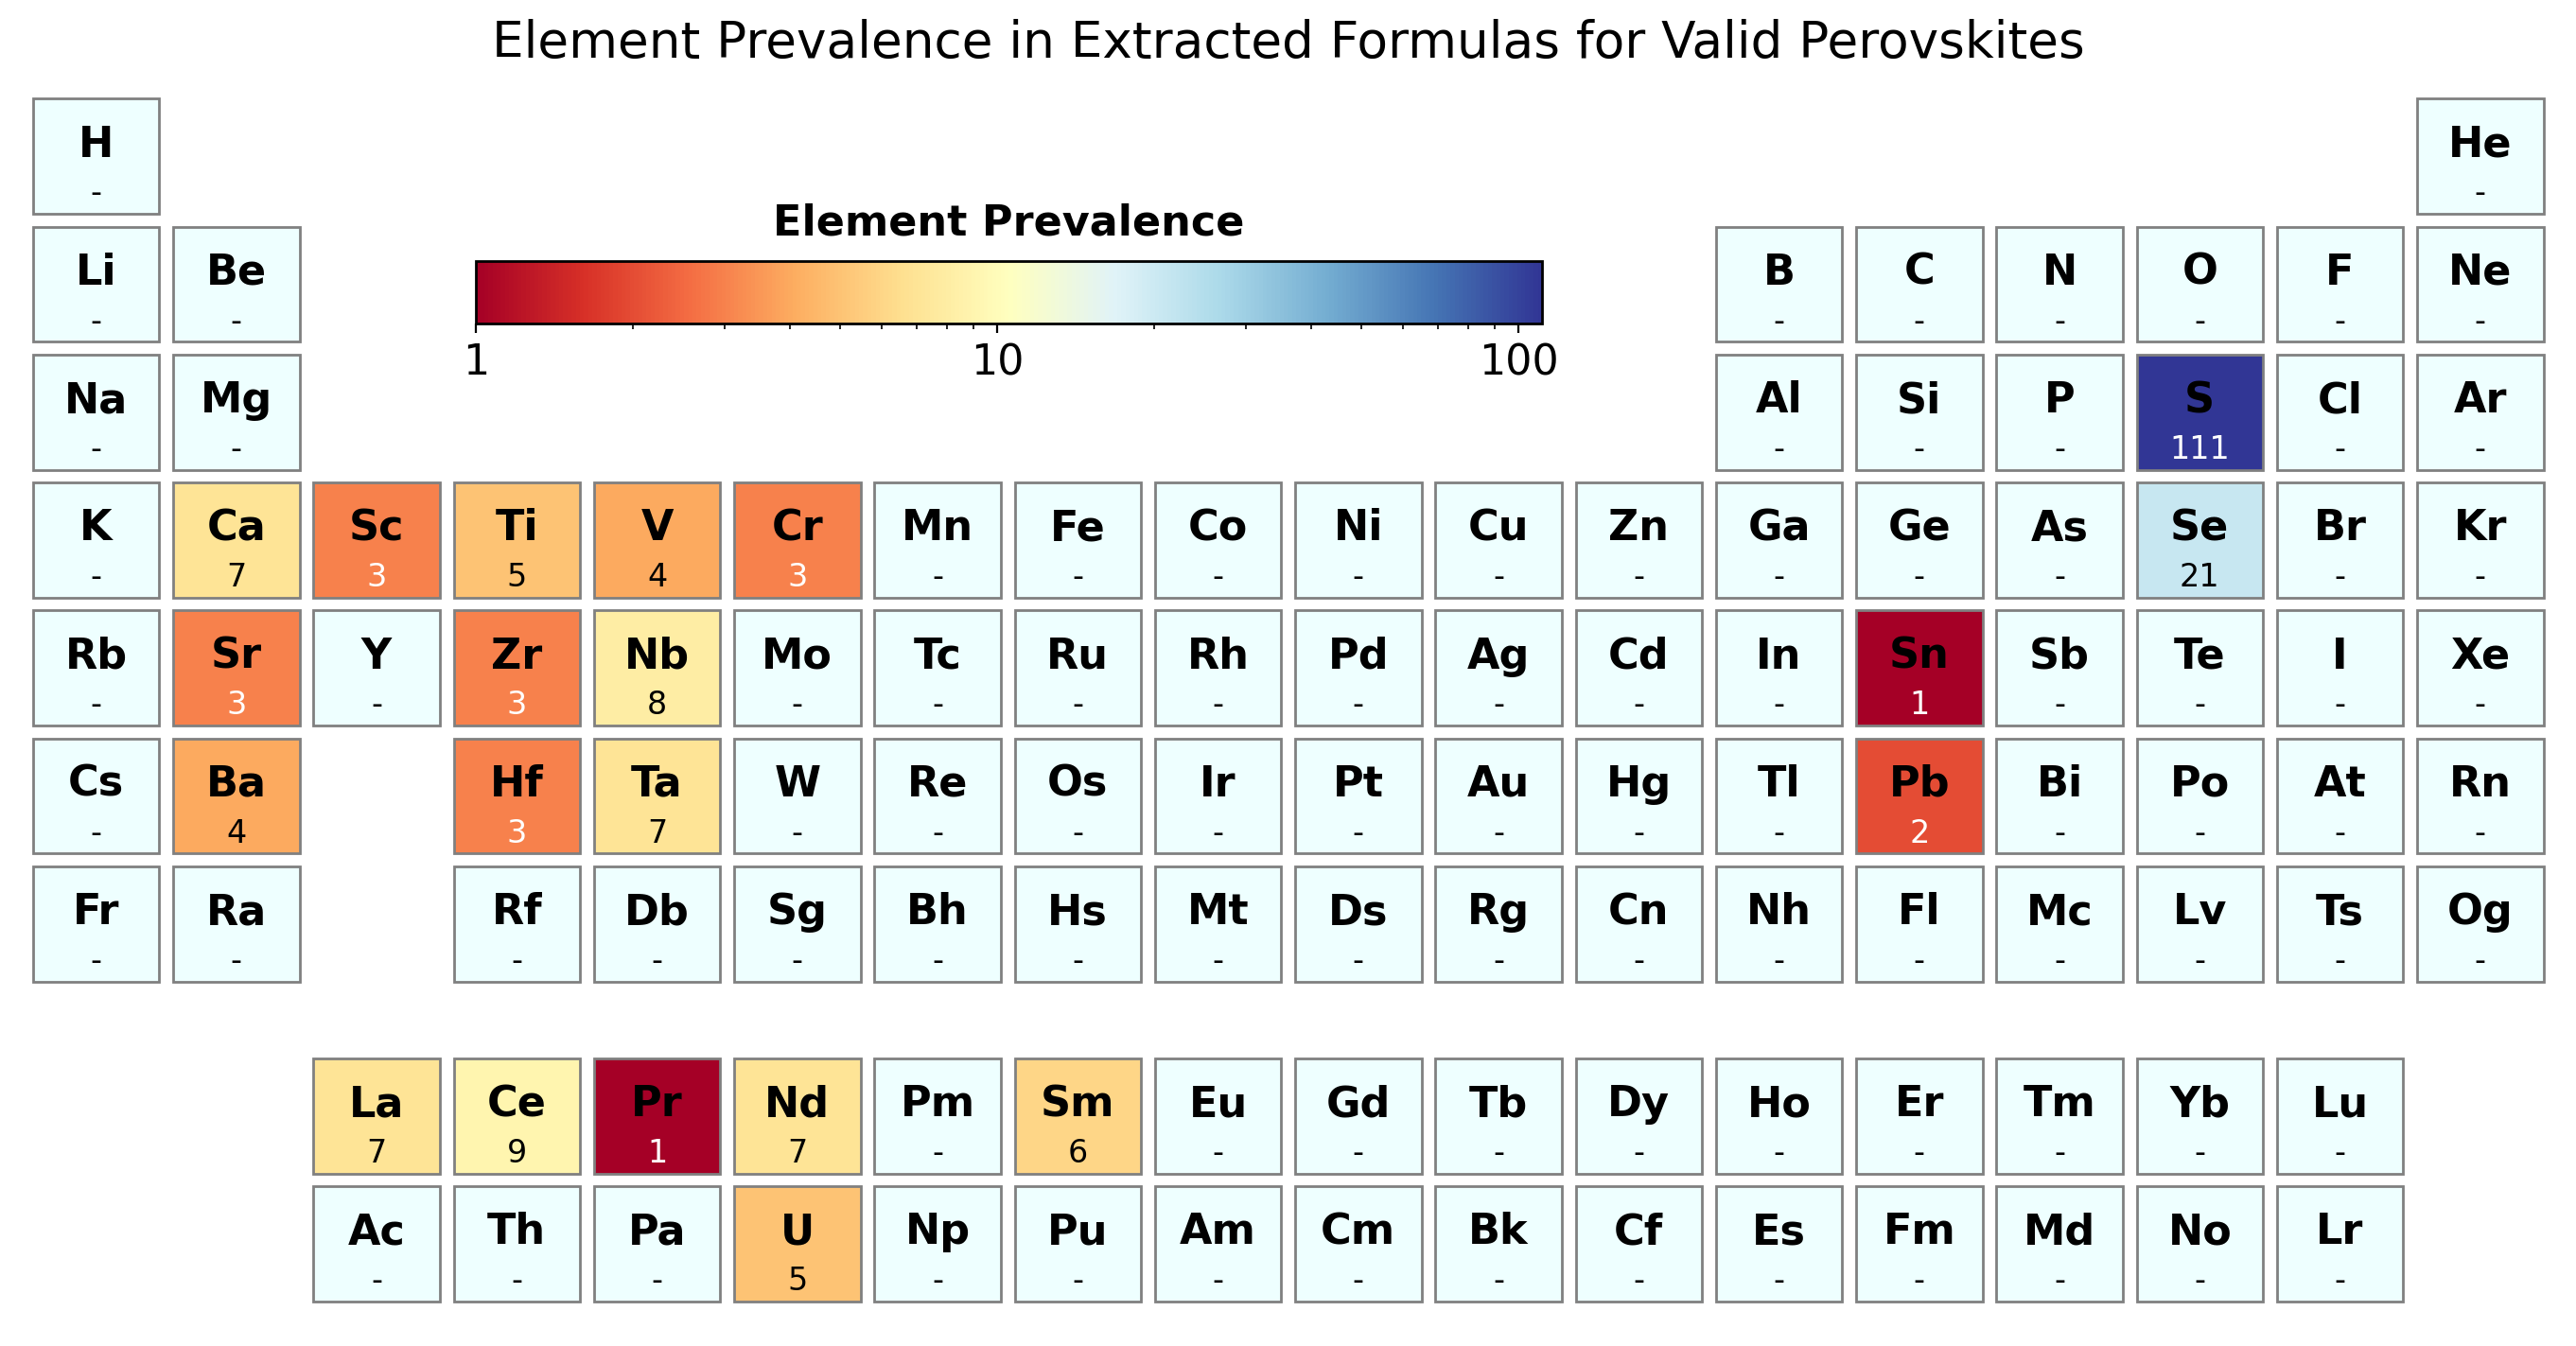

In [ ]:
# Plot the periodic table heatmap
ax2 = ptable_heatmap(
    element_counts_perovskites, cmap="RdYlBu", cbar_title="Element Prevalence", log=True
)
plt.title("Element Prevalence in Extracted Formulas for Valid Perovskites")
plt.show()

```{bibliography}
:filter: docname in docnames

```